In [4]:
import netCDF4 as nc4
import keras
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

In [1]:
file_path =['C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_02.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_03.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_04.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_05.nc')
# file_path.append('C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_06.nc')

In [2]:
file_path

['C:/Users/Administrator/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']

In [3]:
ds = nc4.MFDataset(file_path)
eta_t_arr = ds.variables['eta_t'][:]

NameError: name 'nc4' is not defined

In [9]:
xt_yt = eta_t_arr[0,:,:].shape

Epoch 1/5
469/469 - 37s - loss: 0.6962 - val_loss: 0.6954
Epoch 2/5
469/469 - 34s - loss: 0.6943 - val_loss: 0.6921
Epoch 3/5
469/469 - 34s - loss: 0.6755 - val_loss: 0.6544
Epoch 4/5
469/469 - 35s - loss: 0.6299 - val_loss: 0.6054
Epoch 5/5
469/469 - 34s - loss: 0.5791 - val_loss: 0.5538


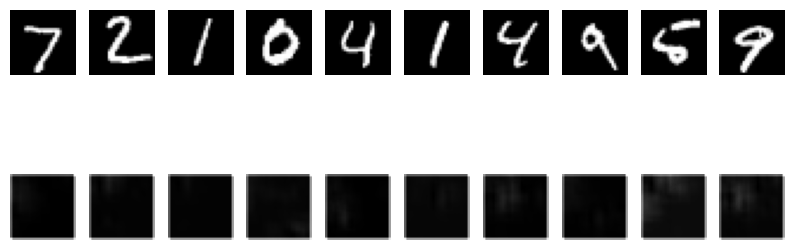

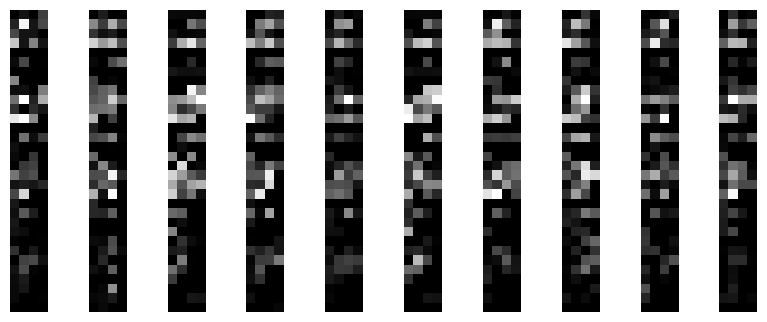

In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

input_img = Input(shape=(28, 28, 1))    # adapt this if using 'channels_first' image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8), i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# To train it, use the original MNIST digits with shape (samples, 3, 28, 28),
# and just normalize pixel values between 0 and 1

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))    # adapt this if using 'channels_first' image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))       # adapt this if using 'channels_first' image data format

# open a terminal and start TensorBoard to read logs in the autoencoder subdirectory
# tensorboard --logdir=autoencoder

autoencoder.fit(x_train, x_train, epochs=5, batch_size=128, shuffle=True, validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='conv_autoencoder')], verbose=2)

# take a look at the reconstructed digits
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

# take a look at the 128-dimensional encoded representation
# these representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images

encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

# save latent space features 128-d vector
pickle.dump(encoded_imgs, open('conv_autoe_features.pickle', 'wb'))

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.set_axis_off()

plt.show()

K.clear_session()